In [1]:
import collections
import re
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Multihead Attention

In [2]:
import math
import torch
from torch import nn
import utils

In [3]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention.

    Defined in :numref:`subsec_additive-attention`"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = utils.masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [4]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention.

    Defined in :numref:`sec_multihead-attention`"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = utils.transpose_qkv(self.W_q(queries), self.num_heads)
        keys = utils.transpose_qkv(self.W_k(keys), self.num_heads)
        values = utils.transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = utils.transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

# 2. Self Attention

## 2.1 Positional encoding

In [5]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [6]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
# d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
#          figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [7]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices.

    Defined in :numref:`sec_attention-cues`"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

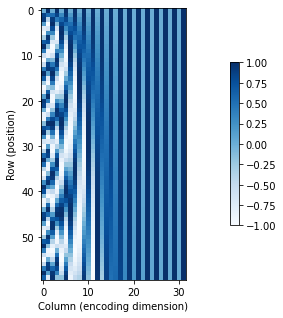

In [8]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(16, 5), cmap='Blues')

## 2.2 Self Attention

In [13]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(4,4,4,num_hiddens, num_heads, 0.5)

In [14]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x100 and 4x100)

# 3. Transformer

In [16]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [17]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

d:\anaconda\envs\py38\lib\site-packages\torch\nn\modules\lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[-0.0507,  0.1370, -0.4999,  0.4261,  0.8059,  0.9174, -0.7425, -0.7939],
        [-0.0507,  0.1370, -0.4999,  0.4261,  0.8059,  0.9174, -0.7425, -0.7939],
        [-0.0507,  0.1370, -0.4999,  0.4261,  0.8059,  0.9174, -0.7425, -0.7939]],
       grad_fn=<SelectBackward>)

In [18]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [21]:
add_norm = AddNorm(4, 0.5)
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4)))

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000, -1.0000,  1.0000],
         [-1.0000,  1.0000,  1.0000, -1.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000,  1.0000, -1.0000],
         [-1.0000,  1.0000,  1.0000, -1.0000]]],
       grad_fn=<NativeLayerNormBackward>)

## 3.1 Encoder